In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [2]:
met_data_dir = '../Data/MetData'
site = 'Auchencorth Moss'
sites = {
    'Auchencorth Moss': 'am_wtd.csv',
    'Hare Moss': 'hm_wtd.csv'
}
perc = 0.87

In [3]:
try: os.chdir(met_data_dir)
except FileNotFoundError: pass

In [4]:
df_raw = pd.read_csv(sites[site])
# df_raw

In [5]:
dates = np.unique(df_raw['Date']).tolist()
dates.sort(key = lambda date: datetime.strptime(date, '%d/%m'))
years = [column for column in list(df_raw.columns) if column not in ('Date','Time')]

f_avg = lambda x: f'wtd_avg_{x}'
f_std = lambda x: f'wtd_std_{x}'

avg_columns = [f(year) for year in years for f in (f_avg,f_std)]

avg_arr = np.zeros((len(dates),len(years)*2))

for i in range(len(dates)):
    date = dates[i]
    daily_mean = np.nanmean(df_raw[df_raw['Date'] == date][years].to_numpy(),axis=0)
    daily_std = np.nanstd(df_raw[df_raw['Date'] == date][years].to_numpy(),axis=0)
    
    new_row = []
    for j in range(len(daily_mean)):
        new_row.append(daily_mean[j])
        new_row.append(daily_std[j])

    avg_arr[i,:] = new_row

C:\Users\s2017658\AppData\Local\Temp\ipykernel_21904\1869695374.py:2: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  dates.sort(key = lambda date: datetime.strptime(date, '%d/%m'))
C:\Users\s2017658\AppData\Local\Temp\ipykernel_21904\1869695374.py:14: RuntimeWarning: Mean of empty slice
  daily_mean = np.nanmean(df_raw[df_raw['Date'] == date][years].to_numpy(),axis=0)
c:\Users\s2017658\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\s2017658\AppData\Local\Temp\ipykernel_21904\1869695374.py:14: RuntimeWar

In [6]:
avg_df = pd.DataFrame(avg_arr,index=dates,columns=avg_columns)

In [7]:
avg_df['wtd_avg_overall'] = np.nanmean(avg_df[[f_avg(year) for year in years]].to_numpy(),axis=1)
avg_df['wtd_std_overall'] = np.nanstd(avg_df[[f_avg(year) for year in years]].to_numpy(),axis=1)

In [8]:
seasonal_dict = {
    'Spr': [3,4,5],
    'Sum': [6,7,8],
    'Aut': [9,10,11],
    'Win': [12,1,2],
}

seasonal_dfs = {}

In [9]:
for season in seasonal_dict:
    seasonal_dfs[season] = avg_df.loc[[date for date in avg_df.index if datetime.strptime(date, "%d/%m").month in seasonal_dict[season]]]
# seasonal_dfs[season]

In [10]:
seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win': '#4B61D1', # Savoy blue
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green
}

Get the upper and lower values corresponding to overall 87% around the 50% percentile. Maybe do so by getting the percentile at 50% - 87%/2 and 50% + 87%/2?

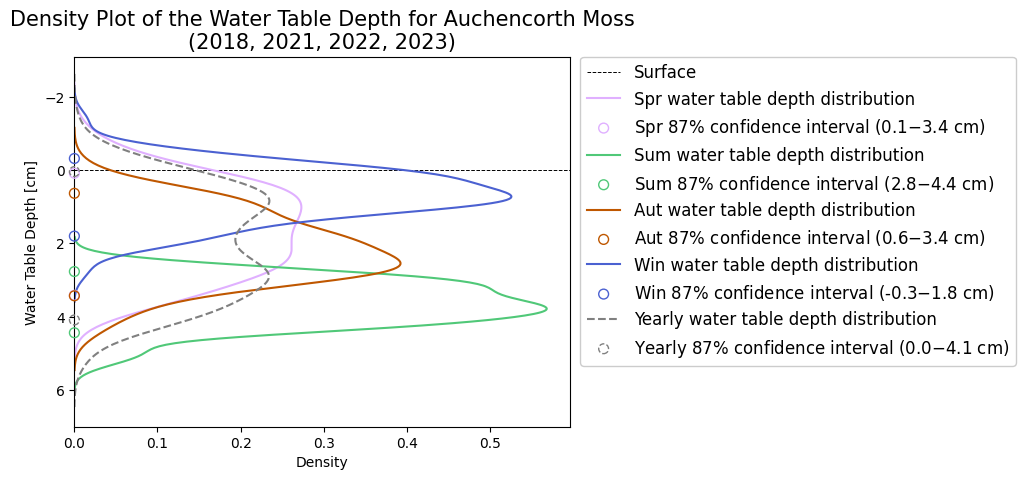

In [13]:
hist_bins = 100
# hist_range = (np.min(avg_df['wtd_avg_overall']),np.max(avg_df['wtd_avg_overall']))
# edges = np.histogram_bin_edges(avg_df['wtd_avg_overall'],bins=hist_bins,range=hist_range)
# counts = {}
mesotelm_limits = {}

fig, ax = plt.subplots()

# xmin, xmax = hist_range
# y = np.linspace(xmin, xmax, hist_bins)

ax.axhline(0,ls='--',c='#000',lw=.7,zorder=-5,label='Surface')

for season in seasonal_dfs:
    # counts[season] = np.histogram(seasonal_dfs[season]['wtd_avg_overall'],bins=hist_bins,range=hist_range)[0]
    # ax.plot(counts[season],edges[:-1],c=seasonal_colours[season])

    mesotelm_limits[season] = [np.quantile(seasonal_dfs[season]['wtd_avg_overall'],0.5-perc/2),np.quantile(seasonal_dfs[season]['wtd_avg_overall'],0.5+perc/2)]
    
    sns.kdeplot(data = seasonal_dfs[season], y = 'wtd_avg_overall',ax=ax,c=seasonal_colours[season],label=f'{season} water table depth distribution')

    # for lim in mesotelm_limits[season]:
    #     ax.axhline(lim,c=seasonal_colours[season],ls='--',lw=1,alpha=0.5)

    ax.scatter([0,0],mesotelm_limits[season],s=50,facecolors='none', edgecolors=seasonal_colours[season],clip_on=False,zorder=5,label=f'{season} {int(perc*100)}% confidence interval ({np.round(np.min(mesotelm_limits[season]),1)}$-${np.round(np.max(mesotelm_limits[season]),1)} cm)')

yearly_colour = 'gray'
sns.kdeplot(data = avg_df, y = 'wtd_avg_overall',ax=ax,c=yearly_colour,label=f'Yearly water table depth distribution',ls='--')
mesotelm_limits['Yearly'] = [np.quantile(avg_df['wtd_avg_overall'],0.5-perc/2),np.quantile(avg_df['wtd_avg_overall'],0.5+perc/2)]
ax.scatter([0,0],mesotelm_limits['Yearly'],ls='--',s=50,facecolors='none', edgecolors=yearly_colour,clip_on=False,zorder=5,label=f'Yearly {int(perc*100)}% confidence interval ({np.round(np.min(mesotelm_limits['Yearly']),1)}$-${np.round(np.max(mesotelm_limits['Yearly']),1)} cm)')

ax.legend(framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)

ax.set_ylim(np.max(ax.get_ylim()),np.min(ax.get_ylim()))
ax.set_xlim(0)

ax.set_xlabel('Density')
ax.set_ylabel('Water Table Depth [cm]')

years_str = ''
for y in years:
    years_str += y
    if y != years[-1]: years_str += ', '
ax.set_title(f'Density Plot of the Water Table Depth for {site}\n({years_str})',fontsize=15)

fig.savefig(f"./{site.replace(' ','_').lower()}_wtd.svg",dpi=600, facecolor = '#fff', bbox_inches='tight')